In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"

# output files/dirs
CADD_SCORE_ENRICHMENT = "../results/cadd_score_enrichment"
CADD_SCORES_GENIC_REGIONS = "../results/cadd_scores_genic_regions"

if not os.path.exists(CADD_SCORE_ENRICHMENT):
    os.makedirs(CADD_SCORE_ENRICHMENT)
    
if not os.path.exists(CADD_SCORES_GENIC_REGIONS):
    os.makedirs(CADD_SCORES_GENIC_REGIONS)

In [3]:
cancer_type = "Liver-HCC"

In [ ]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

In [4]:
# get all mutations in driver genes
mut_df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
driver_genes_list = driver_genes["gene"].tolist()
mut_df = mut_df[mut_df["gene"].isin(driver_genes_list)]
mut_df = pd.merge(mut_df, driver_genes[["gene", "gene_length"]], on="gene", how="left")
mut_df.head()

,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,gene_length
0,ARID1A,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:27077925-27077925:A:G,1:27077925:A:G,False,None,False,intronic,-0.316733,0.400,86072
1,SETDB1,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150909417-150909417:A:G,1:150909417:A:G,False,mutational,True,intronic,0.110056,3.182,38475
2,SETDB1,+,Missense_Mutation,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150933317-150933317:A:C,1:150933317:A:C,True,mutational,True,exonic,5.224169,27.700,38475
3,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46151744-46151744:A:T,12:46151744:A:T,False,None,False,intronic,0.872451,11.090,178376
4,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46259757-46259757:T:G,12:46259757:T:G,False,None,False,intronic,-0.196762,0.710,178376


In [ ]:
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

In [5]:
# filter out indels and MNVs without CADD scores
print(mut_df.shape)
mut_df = mut_df[mut_df["CADD_score_raw"].notnull()]
print(mut_df.shape)
mut_df.reset_index(inplace=True)
print(mut_df.shape)

# normalize CADD scores for each gene
mut_df["CADD_score_normalized"] = mut_df.groupby(["gene"])["CADD_score_raw"].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0.5)

# get driver status
mut_df["has_driver"] = mut_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
mut_df["has_driver"] = mut_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)
mut_df.head()

(6275, 14)
(5781, 14)
(5781, 15)


,index,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,gene_length,CADD_score_normalized
0,0,ARID1A,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:27077925-27077925:A:G,1:27077925:A:G,False,None,Passengers in absence of driver,intronic,-0.316733,0.400,86072,0.056169
1,1,SETDB1,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150909417-150909417:A:G,1:150909417:A:G,False,mutational,Passengers in presence of driver,intronic,0.110056,3.182,38475,0.206421
2,2,SETDB1,+,Missense_Mutation,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150933317-150933317:A:C,1:150933317:A:C,True,mutational,Drivers,exonic,5.224169,27.700,38475,0.932684
3,3,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46151744-46151744:A:T,12:46151744:A:T,False,None,Passengers in absence of driver,intronic,0.872451,11.090,178376,0.183486
4,4,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46259757-46259757:T:G,12:46259757:T:G,False,None,Passengers in absence of driver,intronic,-0.196762,0.710,178376,0.096758


In [6]:
print(mut_df["genic_region"].value_counts())
mut_df["genic_region"] = mut_df["genic_region"].replace({
    "ncRNA_exonic": "ncRNA",
    "ncRNA_intronic": "ncRNA"
})
regions = ["UTR5", "UTR3", "ncRNA", "exonic", "intronic", "splicing", "upstream", "downstream", "intergenic"]
mut_df["genic_region"] = mut_df["genic_region"].apply(lambda x: x if x in regions else "-")
mut_df.to_csv(f"{CADD_SCORES_GENIC_REGIONS}/{cancer_type}.tsv", sep="\t", index=False)
mut_df["genic_region"].value_counts()

intronic          5233
exonic             330
ncRNA_intronic      72
intergenic          65
upstream            20
splicing            19
UTR3                15
ncRNA_exonic        13
downstream          10
UTR5                 4
Name: genic_region, dtype: int64


intronic      5233
exonic         330
ncRNA           85
intergenic      65
upstream        20
splicing        19
UTR3            15
downstream      10
UTR5             4
Name: genic_region, dtype: int64

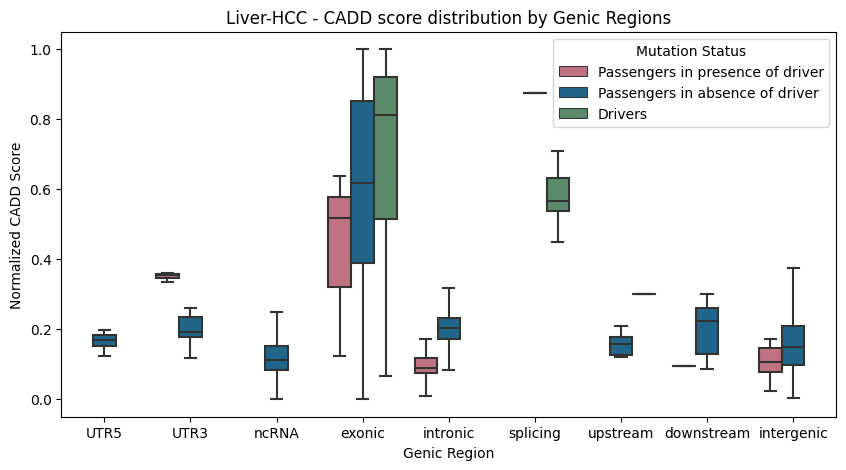

In [7]:
plt.figure(figsize=(10, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
sns.boxplot(
    x="genic_region", 
    y="CADD_score_normalized",
    hue="has_driver",
    data=mut_df,
    palette=cmap,
    order=regions,
    hue_order=hue_order,
    showfliers=False,
)
plt.xlabel("Genic Region")
plt.ylabel("Normalized CADD Score")
plt.legend(title="Mutation Status")
plt.title(f"{cancer_type} - CADD score distribution by Genic Regions")
plt.savefig(f"{CADD_SCORES_GENIC_REGIONS}/{cancer_type}.png", dpi=300, bbox_inches="tight")

In [ ]:
# Enrichment of median CADD scores of samples without driver mutations over samples with driver mutations
passenger_mut_df = mut_df[~mut_df["driver"]] # only passenger mutations
passenger_mut_df["has_driver"] = passenger_mut_df["has_driver"].apply(lambda x: True if x == "Passengers in presence of driver" else False)
group1_median = passenger_mut_df[passenger_mut_df["has_driver"] == "Passengers in presence of driver"]
group2_median = passenger_mut_df[passenger_mut_df["has_driver"] == "Passengers in absence of driver"]

tumor_mut_grouped_df = passenger_mut_df.groupby(["has_driver", "genic_region"]).agg({
    "CADD_score_normalized": "median"
}).reset_index()
tumor_mut_grouped_df = tumor_mut_grouped_df.pivot(index="genic_region", columns="has_driver", values="CADD_score_normalized").fillna(0)
# add True and False columns if they don't exist
if True not in tumor_mut_grouped_df.columns:
    tumor_mut_grouped_df[True] = 0
if False not in tumor_mut_grouped_df.columns:
	tumor_mut_grouped_df[False] = 0
tumor_mut_grouped_df["enrichment"] = (tumor_mut_grouped_df[False] + 1e-6) / (tumor_mut_grouped_df[True] + 1e-6)
tumor_mut_grouped_df.to_csv(f"{CADD_SCORE_ENRICHMENT}/{cancer_type}.tsv", sep="\t")
tumor_mut_grouped_df

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_18631/128827818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_mut_df["has_driver"] = passenger_mut_df["has_driver"].apply(lambda x: True if x == "Passengers in presence of driver" else False)


has_driver,False,True,enrichment
genic_region,,,
UTR3,0.191811,0.354340,5.413177e-01
UTR5,0.168951,0.000000,1.689509e+08
downstream,0.223461,0.095361,2.343301e+00
exonic,0.618897,0.516973,1.197156e+00
intergenic,0.149478,0.106007,1.410083e+00
intronic,0.204134,0.090355,2.259243e+00
ncRNA,0.111279,0.000000,1.112790e+08
splicing,0.874431,0.000000,8.744306e+08
upstream,0.156597,0.000000,1.565971e+08
